# Natural Language Analytics

## Exercise 3 - Topic Modeling and NER

### Nikolaos Nikolaou - DSC18014

## Question A

First let's load our libraries and our data

In [1]:
import pandas as pd
import glob
import os
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics.pairwise import euclidean_distances
import pyLDAvis.sklearn

After we download we take a peek

In [2]:
subdir = os.listdir('nipstxt')
print(subdir)

['idx', 'MATLAB_NOTES', 'nips00', 'nips01', 'nips02', 'nips03', 'nips04', 'nips05', 'nips06', 'nips07', 'nips08', 'nips09', 'nips10', 'nips11', 'nips12', 'orig', 'RAW_DATA_NOTES', 'README_yann']


Let's exclude the files and folders that notes, indices and the orig folder

In [3]:
subdir = [ item for item in subdir if "nips" in item]
print(subdir)

['nips00', 'nips01', 'nips02', 'nips03', 'nips04', 'nips05', 'nips06', 'nips07', 'nips08', 'nips09', 'nips10', 'nips11', 'nips12']


In [4]:
lst_docs = []
for dirs in subdir:
   path = 'nipstxt/' + dirs + '/*.txt'
   files = glob.glob(path)
   for name in files:
       with open(name, encoding="utf8", errors='ignore') as f:
            lst_docs.append(f.read())

Ok, now we have all our documents as items in a list.
As a next step we will process the texts and transform the to vectors.
We will experiment with computing both the inverse term frequency (TFIDF vectorizer)and Term frequency (sklearn's Count Vectorizer).

#### TFIDF Vectorizer

We choose to tokenize by english words that are 3 lettered and longer. We also consider to tokenizer by unigrams

In [5]:
extr = TfidfVectorizer(min_df=5, max_df=0.9, max_features=None, strip_accents='unicode', lowercase=True, analyzer='word',
                       token_pattern=r'\w{3,}', ngram_range=(1, 1), use_idf=True, smooth_idf=True,
                       sublinear_tf=True, stop_words="english")

Let's vectorize our data

In [6]:
transformed_data = extr.fit_transform(lst_docs)

Sklearn assumes alpha=1/n_components if no value is entered for doc_topic_prior. So in our exercise we will test for n_components 10 and 100. So our alpha will be 0.1 and 0.01

In [7]:
NUM_TOPICS = 10
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(transformed_data)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

(1740, 10)


Let's see how the first document in the corpus looks like in different topic spaces

In [8]:
print(lda_Z[0])

[0.0054279  0.0054279  0.0054279  0.0054279  0.95114892 0.0054279
 0.0054279  0.0054279  0.0054279  0.0054279 ]


In [9]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])
        print("Most representative document: ", np.argmax(topic))

print_topics(lda_model, extr)

Topic 0:
[('associative', 0.10037403013686845), ('network', 0.10036681251489098), ('signals', 0.10035448350588128), ('memory', 0.10034439221736556), ('output', 0.10034081357200487), ('threshold', 0.10034024581620381), ('number', 0.10033808087676485), ('energy', 0.10033761619467327), ('phase', 0.10033540230068498), ('neuromorphic', 0.10033381295851883)]
Most representative document:  2585
Topic 1:
[('nets', 0.10035082650995404), ('input', 0.10031503648432241), ('hidden', 0.1003042799692827), ('rumelhart', 0.10030282155459516), ('hinton', 0.1002993647218914), ('matrix', 0.10029822164244968), ('error', 0.10029801550155187), ('previously', 0.10029763201646975), ('net', 0.10029756439265569), ('propagation', 0.10029738452889243)]
Most representative document:  10793
Topic 2:
[('network', 0.10043118080898243), ('sonn', 0.10038936634096271), ('nodes', 0.10038228991284942), ('subsystem', 0.10037550784740924), ('neuron', 0.10037256602614483), ('node', 0.10037189876431664), ('output', 0.100354473

wow, only one describes best the tokens. Let's see the distribution of topics across the documents

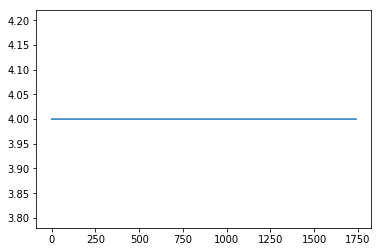

In [10]:
win_topic=[np.argmax(topics) for topics in lda_Z]
plt.plot(win_topic)
plt.show()

As expected... all documents could belong to topic 7

Let's assume a new text and try to find the most similar document from our dataset

In [11]:
text = "the vlsi network makes no sense"
x = lda_model.transform(extr.transform([text]))[0]
print(x)

[0.034524 0.034524 0.034524 0.034524 0.689284 0.034524 0.034524 0.034524
 0.034524 0.034524]


In [12]:
def most_similar(x, Z, top_n=5):
    dists = euclidean_distances(x.reshape(1, -1), Z)
    pairs = enumerate(dists[0])
    most_similar = sorted(pairs, key=lambda item: item[1])[:top_n]
    return most_similar
 
similarities = most_similar(x, lda_Z)
document_id, similarity = similarities[0]
print(lst_docs[document_id][:1000])

795 
SONG LEARNING IN BIRDS 
M. Konishi 
Division of Biology 
California Institute of Technology 
ABSTRACT
Birds sing to communicate. Male birds use song to advertise their territories and 
attract females. Each bird species has a unique song or set of songs. Song conveys 
both species and individual identity. In most species, young birds learn some fea- 
tures of adult song. Song develops gradually from amorphous to fixed patterns of 
vocalization as if crystals form out of liquid. Learning of a song proceeds in two 
steps; birds commit the song to memory in the first stage and then they vocally 
reproduce it in the second stage. The two stages overlap each other in some species, 
while they are separated by several months in other species. The ability of a bird to 
commit a song to memory is restricted to a period known as the sensitive phase. Vo- 
cal reproduction of the memorized song requires auditory feedback. Birds deafened 
before the second stage cannot reproduce the memorized

To visualise the results of LDA let's import pyLDAvis

In [13]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, transformed_data, extr, mds='tsne', sort_topics=False)
panel

/home/nick/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0     -144.456497  -49.779041       1        1   0.453359
1      -69.923988  303.390869       2        1   0.453359
2     -404.963562  296.399658       3        1   0.453359
3      479.929321  177.864563       4        1   0.453359
4      223.603714  464.482727       5        1  95.919767
5     -492.022461  -79.065750       6        1   0.453359
6     -256.124207 -399.875244       7        1   0.453359
7      103.061279 -359.934143       8        1   0.453359
8      436.004425 -217.753937       9        1   0.453359
9      164.591248   29.950375      10        1   0.453359, topic_info=      Category       Freq          Term      Total  loglift  logprob
term                                                                
16280  Default  25.000000         units  25.000000  30.0000  30.0000
14184  Default  24.000000         shown  24.000000  29.0000  29.0000
14743  Default  26.000000         state  26.000000  28.0000  28.0000
3514   Default  25.000000          case  25.000000  27.0000  27.0000
9480   Default  25.000000        linear  25.000000  26.0000  26.0000
11338  Default  24.000000         order  24.000000  25.0000  25.0000
10387  Default  25.000000        models  25.000000  24.0000  24.0000
16795  Default  24.000000       weights  24.000000  23.0000  23.0000
16444  Default  24.000000         value  24.000000  22.0000  22.0000
16446  Default  24.000000        values  24.000000  21.0000  21.0000
14544  Default  25.000000         space  25.000000  20.0000  20.0000
16389  Default  25.000000           use  25.000000  19.0000  19.0000
2880   Default  25.000000         based  25.000000  18.0000  18.0000
5311   Default  26.000000     different  26.000000  17.0000  17.0000
11578  Default  24.000000    parameters  24.000000  16.0000  16.0000
15317  Default  23.000000       systems  23.000000  15.0000  15.0000
9291   Default  23.000000         layer  23.000000  14.0000  14.0000
16496  Default  25.000000        vector  25.000000  13.0000  13.0000
11765  Default  25.000000   performance  25.000000  12.0000  12.0000
10863  Default  23.000000           new  23.000000  11.0000  11.0000
7713   Default  24.000000        hidden  24.000000  10.0000  10.0000
5541   Default  24.000000  distribution  24.000000   9.0000   9.0000
12378  Default  25.000000   probability  25.000000   8.0000   8.0000
2392   Default  24.000000      approach  24.000000   7.0000   7.0000
8382   Default  27.000000   information  27.000000   6.0000   6.0000
10174  Default  23.000000        method  23.000000   5.0000   5.0000
7111   Default  23.000000     functions  23.000000   4.0000   4.0000
6347   Default  23.000000       example  23.000000   3.0000   3.0000
10937  Default  22.000000         noise  22.000000   2.0000   2.0000
14318  Default  22.000000        single  22.000000   1.0000   1.0000
...        ...        ...           ...        ...      ...      ...
3584   Topic10   0.009705          cell  15.536117  -1.9820  -9.7472
6751   Topic10   0.009705           fig  19.123375  -2.1898  -9.7473
15172  Topic10   0.009704       suppose   8.763368  -1.4095  -9.7474
14301  Topic10   0.009704   simulations  14.036583  -1.8806  -9.7474
10122  Topic10   0.009704        memory  15.237974  -1.9628  -9.7474
14743  Topic10   0.009704         state  26.308383  -2.5089  -9.7474
1884   Topic10   0.009703      activity  15.802624  -1.9993  -9.7475
16446  Topic10   0.009703        values  24.679234  -2.4451  -9.7475
7837   Topic10   0.009702      hopfield   7.953531  -1.3128  -9.7475
11677  Topic10   0.009702      patterns  19.655740  -2.2175  -9.7476
14747  Topic10   0.009702        states  17.896954  -2.1238  -9.7476
3585   Topic10   0.009702         cells  15.692225  -1.9923  -9.7476
15285  Topic10   0.009702      synaptic  13.110234  -1.8126  -9.7476
15944  Topic10   0.009702        travel   1.943835   0.0962  -9.7476
2492   Topic10   0

Well, one topic seems to dominate the majority of tokens. Here counting starts from 1, so it's the same as the previously found

In [14]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(transformed_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(transformed_data))

Log Likelihood:  -368695.5980004975
Perplexity:  23565.897090662293


Let's do a grid search

In [15]:
# Define Search Param
search_params = {'doc_topic_prior':[.01,.1,.2,.5],'n_components': [5, 10, 50], 'learning_decay': [.2, .5, .7]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=10, learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(transformed_data)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed_data))

lda_Z = best_lda_model.fit_transform(transformed_data)
#distribution
win_topic=[np.argmax(topics) for topics in lda_Z]

/home/nick/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Model's Params:  {'doc_topic_prior': 0.01, 'learning_decay': 0.7, 'n_components': 5}
Best Log Likelihood Score:  -128406.714363079
Model Perplexity:  16630.625345615343


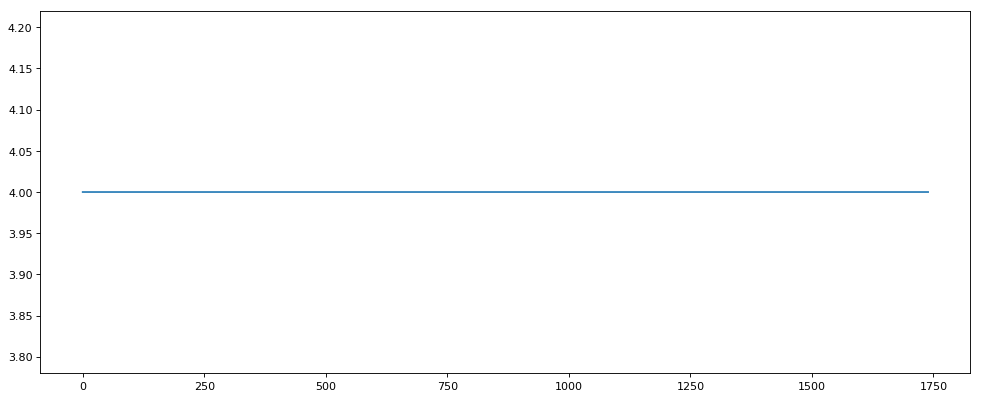

In [18]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(win_topic)
plt.show()

In [19]:
print_topics(lda_model, extr)

Topic 0:
[('associative', 0.10037403013686845), ('network', 0.10036681251489098), ('signals', 0.10035448350588128), ('memory', 0.10034439221736556), ('output', 0.10034081357200487), ('threshold', 0.10034024581620381), ('number', 0.10033808087676485), ('energy', 0.10033761619467327), ('phase', 0.10033540230068498), ('neuromorphic', 0.10033381295851883)]
Most representative document:  2585
Topic 1:
[('nets', 0.10035082650995404), ('input', 0.10031503648432241), ('hidden', 0.1003042799692827), ('rumelhart', 0.10030282155459516), ('hinton', 0.1002993647218914), ('matrix', 0.10029822164244968), ('error', 0.10029801550155187), ('previously', 0.10029763201646975), ('net', 0.10029756439265569), ('propagation', 0.10029738452889243)]
Most representative document:  10793
Topic 2:
[('network', 0.10043118080898243), ('sonn', 0.10038936634096271), ('nodes', 0.10038228991284942), ('subsystem', 0.10037550784740924), ('neuron', 0.10037256602614483), ('node', 0.10037189876431664), ('output', 0.100354473

In [20]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(transformed_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(transformed_data))

Log Likelihood:  -368695.5980004975
Perplexity:  23565.897090662293


Let's try to change the way we represent our features and see how LDA responds

Again for a =0.1

In [21]:
extr = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern=r'\w{3,}')
transformed_data = extr.fit_transform(lst_docs)
NUM_TOPICS = 10

# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(transformed_data)
#distribution
win_topic=[np.argmax(topics) for topics in lda_Z]

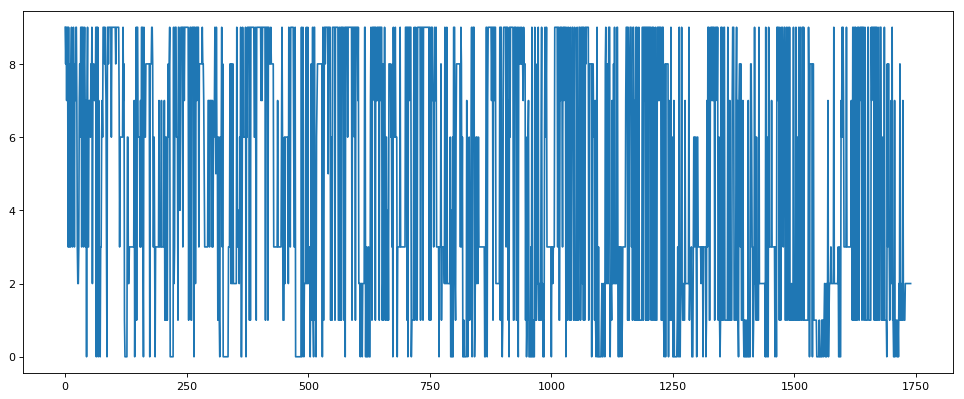

In [22]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(win_topic)
plt.show()

In [23]:
print_topics(lda_model, extr)

Topic 0:
[('image', 4030.033718856178), ('images', 2691.858931674281), ('visual', 2448.5934740670837), ('figure', 2315.7139364720356), ('model', 2179.4397332436365), ('object', 1896.2748838410635), ('motion', 1737.384889525768), ('network', 1407.6262614272393), ('feature', 1372.0045818847925), ('field', 1330.8417164600116)]
Most representative document:  8101
Topic 1:
[('data', 9279.219225729743), ('model', 5918.773231773933), ('set', 3773.9947021058606), ('models', 3367.1996065163253), ('training', 3350.354250145753), ('algorithm', 2794.516855900437), ('gaussian', 2720.871489658403), ('distribution', 2495.174168194185), ('parameters', 2488.7979053223976), ('classification', 2224.5509399339367)]
Most representative document:  4881
Topic 2:
[('learning', 5024.979172869172), ('state', 4375.6590515747475), ('control', 2794.9061294236076), ('time', 2721.392427448289), ('model', 2098.467613637453), ('value', 1638.8592744891323), ('policy', 1572.1748513841558), ('action', 1488.3558243006576)

In [24]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(transformed_data))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(transformed_data))

Log Likelihood:  -19470516.22937985
Perplexity:  2687.6923252126453


In [ ]:
# pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, transformed_data, extr, mds='tsne', sort_topics=False)
panel

With the Count Vectorizer we have a more meaningful result. Topic 7 is slightly more popular that the others.

Let's do a grid search.

Best Model's Params:  {'doc_topic_prior': 0.1, 'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -6764279.084158629
Model Perplexity:  2842.47272613707


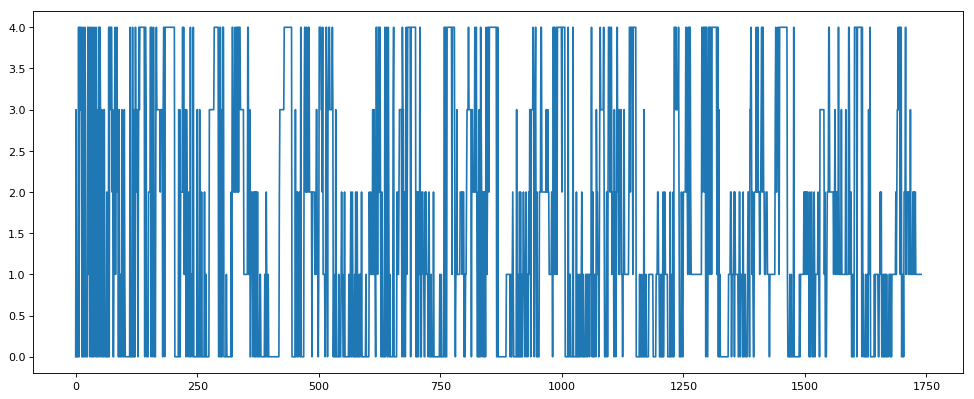

In [25]:
# Define Search Param
search_params = {'doc_topic_prior':[.01,.1,.2,.5],'n_components': [5, 10, 50], 'learning_decay': [.2, .5, .7]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=10, learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(transformed_data)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed_data))

lda_Z = best_lda_model.fit_transform(transformed_data)
#distribution
win_topic=[np.argmax(topics) for topics in lda_Z]

figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(win_topic)
plt.show()

## Question B

In [34]:
import collections
ner_tags = collections.Counter()
corpus_root = "gmb-2.2.0" 
 
for root, dirs, files in os.walk(corpus_root):
    for filename in files:
        if filename.endswith(".tags"):
            with open(os.path.join(root, filename), 'rb') as file_handle:
                file_content = file_handle.read().decode('utf-8').strip()
                annotated_sentences = file_content.split('\n\n')   # Split sentences
                for annotated_sentence in annotated_sentences:
                    annotated_tokens = [seq for seq in annotated_sentence.split('\n') if seq]  # Split words
 
                    standard_form_tokens = []
 
                    for idx, annotated_token in enumerate(annotated_tokens):
                        annotations = annotated_token.split('\t')   # Split annotation
                        word, tag, ner = annotations[0], annotations[1], annotations[3]
 
                        # Get only the primary category
                        if ner != 'O':
                            ner = ner.split('-')[0]
 
                        ner_tags[ner] += 1
print(ner_tags)
 
print("Words=", sum(ner_tags.values()))

Counter({'O': 1146068, 'geo': 58388, 'org': 48094, 'per': 44254, 'tim': 34789, 'gpe': 20680, 'art': 867, 'eve': 709, 'nat': 300})
Words= 1354149


In [35]:
import string
from nltk.stem.snowball import SnowballStemmer

def features(tokens, index, history):
    """
    `tokens`  = a POS-tagged sentence [(w1, t1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
 
    # init the stemmer
    stemmer = SnowballStemmer('english')
 
    # Pad the sequence with placeholders
    tokens = [('[START2]', '[START2]'), ('[START1]', '[START1]')] + list(tokens) + [('[END1]', '[END1]'), ('[END2]', '[END2]')]
    history = ['[START2]', '[START1]'] + list(history)
 
    # shift the index with 2, to accommodate the padding
    index += 2
 
    word, pos = tokens[index]
    prevword, prevpos = tokens[index - 1]
    prevprevword, prevprevpos = tokens[index - 2]
    nextword, nextpos = tokens[index + 1]
    nextnextword, nextnextpos = tokens[index + 2]
    previob = history[index - 1]
    contains_dash = '-' in word
    contains_dot = '.' in word
    allascii = all([True for c in word if c in string.ascii_lowercase])
 
    allcaps = word == word.capitalize()
    capitalized = word[0] in string.ascii_uppercase
 
    prevallcaps = prevword == prevword.capitalize()
    prevcapitalized = prevword[0] in string.ascii_uppercase
 
    nextallcaps = prevword == prevword.capitalize()
    nextcapitalized = prevword[0] in string.ascii_uppercase
 
    return {
        'word': word,
        'lemma': stemmer.stem(word),
        'pos': pos,
        'all-ascii': allascii,
 
        'next-word': nextword,
        'next-lemma': stemmer.stem(nextword),
        'next-pos': nextpos,
 
        'next-next-word': nextnextword,
        'nextnextpos': nextnextpos,
 
        'prev-word': prevword,
        'prev-lemma': stemmer.stem(prevword),
        'prev-pos': prevpos,
 
        'prev-prev-word': prevprevword,
        'prev-prev-pos': prevprevpos,
 
        'prev-iob': previob,
 
        'contains-dash': contains_dash,
        'contains-dot': contains_dot,
 
        'all-caps': allcaps,
        'capitalized': capitalized,
 
        'prev-all-caps': prevallcaps,
        'prev-capitalized': prevcapitalized,
 
        'next-all-caps': nextallcaps,
        'next-capitalized': nextcapitalized,
    }

In [36]:
def to_conll_iob(annotated_sentence):
    """
    `annotated_sentence` = list of triplets [(w1, t1, iob1), ...]
    Transform a pseudo-IOB notation: O, PERSON, PERSON, O, O, LOCATION, O
    to proper IOB notation: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    """
    proper_iob_tokens = []
    for idx, annotated_token in enumerate(annotated_sentence):
        tag, word, ner = annotated_token
 
        if ner != 'O':
            if idx == 0:
                ner = "B-" + ner
            elif annotated_sentence[idx - 1][2] == ner:
                ner = "I-" + ner
            else:
                ner = "B-" + ner
        proper_iob_tokens.append((tag, word, ner))
    return proper_iob_tokens
 

def read_gmb(corpus_root):
    for root, dirs, files in os.walk(corpus_root):
        for filename in files:
            if filename.endswith(".tags"):
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\n') if seq]
 
                        standard_form_tokens = []
 
                        for idx, annotated_token in enumerate(annotated_tokens):
                            annotations = annotated_token.split('\t')
                            word, tag, ner = annotations[0], annotations[1], annotations[3]
 
                            if ner != 'O':
                                ner = ner.split('-')[0]
 
                            if tag in ('LQU', 'RQU'):   # Make it NLTK compatible
                                tag = "``"
 
                            standard_form_tokens.append((word, tag, ner))
 
                        conll_tokens = to_conll_iob(standard_form_tokens)
 
                        # Make it NLTK Classifier compatible - [(w1, t1, iob1), ...] to [((w1, t1), iob1), ...]
                        # Because the classfier expects a tuple as input, first item input, second the class
                        yield [((w, t), iob) for w, t, iob in conll_tokens]

reader = read_gmb(corpus_root)

In [37]:
print (next(reader))

[(('Thousands', 'NNS'), 'O'), (('of', 'IN'), 'O'), (('demonstrators', 'NNS'), 'O'), (('have', 'VBP'), 'O'), (('marched', 'VBN'), 'O'), (('through', 'IN'), 'O'), (('London', 'NNP'), 'B-geo'), (('to', 'TO'), 'O'), (('protest', 'VB'), 'O'), (('the', 'DT'), 'O'), (('war', 'NN'), 'O'), (('in', 'IN'), 'O'), (('Iraq', 'NNP'), 'B-geo'), (('and', 'CC'), 'O'), (('demand', 'VB'), 'O'), (('the', 'DT'), 'O'), (('withdrawal', 'NN'), 'O'), (('of', 'IN'), 'O'), (('British', 'JJ'), 'B-gpe'), (('troops', 'NNS'), 'O'), (('from', 'IN'), 'O'), (('that', 'DT'), 'O'), (('country', 'NN'), 'O'), (('.', '.'), 'O')]


In [38]:
import pickle
from collections import Iterable
from nltk.tag import ClassifierBasedTagger
from nltk.chunk import ChunkParserI, conlltags2tree, tree2conlltags
 

class NamedEntityChunker(ChunkParserI):
    def __init__(self, train_sents, **kwargs):
        assert isinstance(train_sents, Iterable)
 
        self.feature_detector = features
        self.tagger = ClassifierBasedTagger(
            train=train_sents,
            feature_detector=features,
            **kwargs)
 
    def parse(self, tagged_sent):
        chunks = self.tagger.tag(tagged_sent)
 
        # Transform the result from [((w1, t1), iob1), ...] 
        # to the preferred list of triplets format [(w1, t1, iob1), ...]
        iob_triplets = [(w, t, c) for ((w, t), c) in chunks]
 
        # Transform the list of triplets to nltk.Tree format
        return conlltags2tree(iob_triplets)

In [39]:
reader = read_gmb(corpus_root)
data = list(reader)
training_samples = data[:int(len(data) * 0.9)]
test_samples = data[int(len(data) * 0.9):]
 
print ("#training samples = %s" % len(training_samples))
print ("#test samples = %s" % len(test_samples)  )

#training samples = 55809
#test samples = 6201


In [40]:
chunker = NamedEntityChunker(training_samples[:2000])

In [41]:
from nltk import pos_tag, word_tokenize
print (chunker.parse(pos_tag(word_tokenize("I'm going to Germany this Monday."))))

(S
  (gpe I/PRP)
  'm/VBP
  going/VBG
  to/TO
  (geo Germany/NNP)
  this/DT
  (tim Monday/NNP)
  ./.)
